# Dense optic flow

Analysing the movement around the initial R-VP to find a better R-VP

In [1]:
import os
import cv2
from cv2.typing import MatLike
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_file(id:int):
    """Get the file path of the video with the given id

    Args:
        id (int): id of video in dataset

    Returns:
        string: file path to the video
    """
    # fill 2 zeros to the left of the id
    id = str(id).zfill(3)
    return '/home/aap9002/Dataset/day/{id}/R_calibrated.mov'.format(id=id)

configure the parameters

In [3]:
ids = [55]

# Prepare videos

In [4]:
def check_file_exists(file:int):
    """check if file exists

    Args:
        file (int): video number in dataset

    Returns:
        bool: True if file exists, False otherwise
    """
    if os.path.exists(file):
        return True
    print('File does not exist: ', file)
    return False

files = [get_file(id) for id in ids]
files = [file for file in files if check_file_exists(file)]

files

['/home/aap9002/Dataset/day/055/R_calibrated.mov']

In [5]:
def crop_around_point(frame:MatLike, x:int, y:int, size:int, ratio= (2,1)):
    size_x = size * ratio[0]
    size_y = size * ratio[1]

    frame = frame[y-size_y:y+size_y, x-size_x:x+size_x]
    return frame

def get_frame(cap:cv2.VideoCapture, frame_number:int):
    """get frame based on frame number

    Args:
        cap (cv2.VideoCapture): current video capture
        frame_number (int): frame number to get

    Returns:
        MatLike: frame
    """
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
        print('Error reading frame: ', frame_number)
        return None
    
    grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return grey

# Dense optic flow

In [6]:
def get_dense_optic_flow_between_frames(frame1, frame2):
    flow = cv2.calcOpticalFlowFarneback(frame1, frame2,  
                                       None, 
                                       0.5, 3, 15, 3, 5, 1.2, 0) 
    return flow

## Test two frames

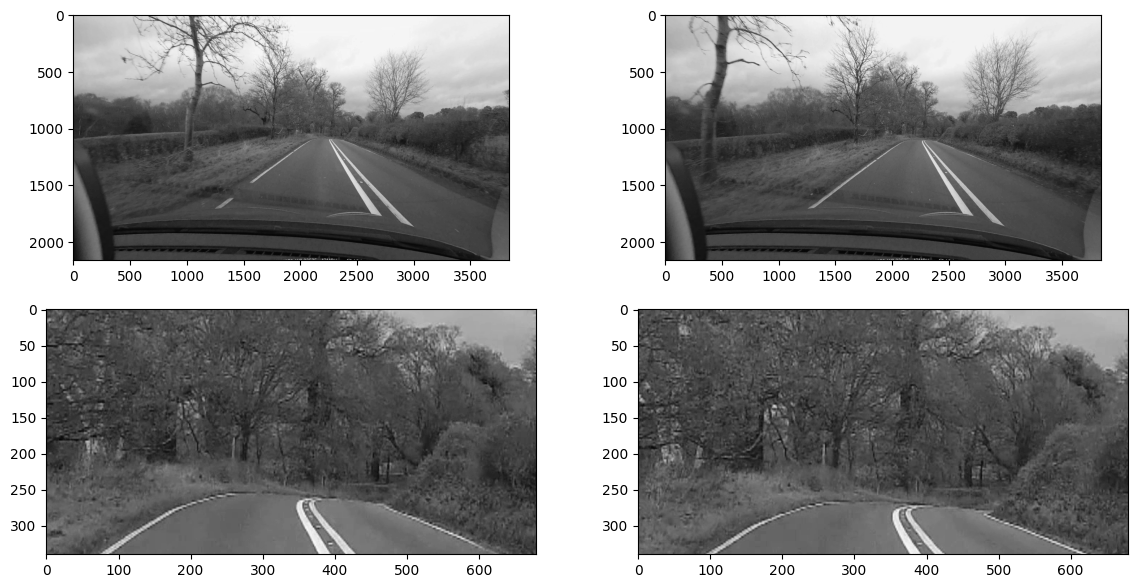

In [16]:
left_bend_frame = 500
right_bend_frame = 1900
straight_road_frame = 400

current_focus = right_bend_frame

test_frame = get_frame(cv2.VideoCapture(files[0]), current_focus)
test_next_frame = get_frame(cv2.VideoCapture(files[0]), current_focus+5)
test_frame_cropped = crop_around_point(test_frame, 2250, 1000, 170)
test_next_cropped = crop_around_point(test_next_frame, 2250, 1000, 170)

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(14, 7)
ax[0, 0].imshow(test_frame, cmap='gray')
ax[0, 1].imshow(test_next_frame, cmap='gray')
ax[1, 0].imshow(test_frame_cropped, cmap='gray')
ax[1, 1].imshow(test_next_cropped, cmap='gray')


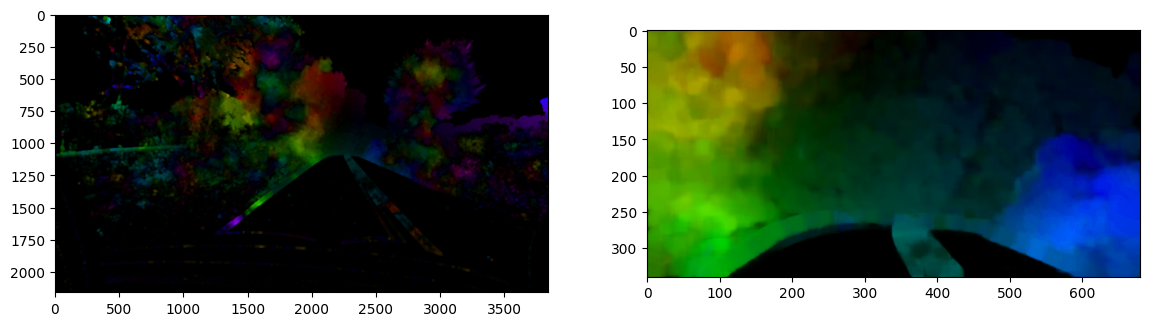

In [17]:
def get_dense_optic_flow_image(frame:MatLike, next_frame:MatLike):
    """ Get the dense optical flow between two frames
    https://www.geeksforgeeks.org/python-opencv-dense-optical-flow/

    Args:
        frame (MatLike): current frame
        next_frame (MatLike): next frame

    Returns:
        MatLike: dense optical flow image
    """
    mask = np.zeros((frame.shape[0], frame.shape[1], 3), dtype=np.uint8)
  
    # Sets image saturation to maximum 
    mask[..., 1] = 255
    
    flow = get_dense_optic_flow_between_frames(frame, next_frame)

    # Computes the magnitude and angle of the 2D vectors 
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        
    # Sets image hue according to the optical flow  
    # direction 
    mask[..., 0] = angle * 180 / np.pi / 2
        
    # Sets image value according to the optical flow 
    # magnitude (normalized) 
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX) 
        
    # Converts HSV to RGB (BGR) color representation 
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR) 

    return rgb, magnitude, angle
        
wide_image, _, _ = get_dense_optic_flow_image(test_frame, test_next_frame)
narrow_image, magnitude, angle = get_dense_optic_flow_image(test_frame_cropped, test_next_cropped)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 7)
ax[0].imshow(wide_image)
ax[1].imshow(narrow_image)

# Analyse the movement

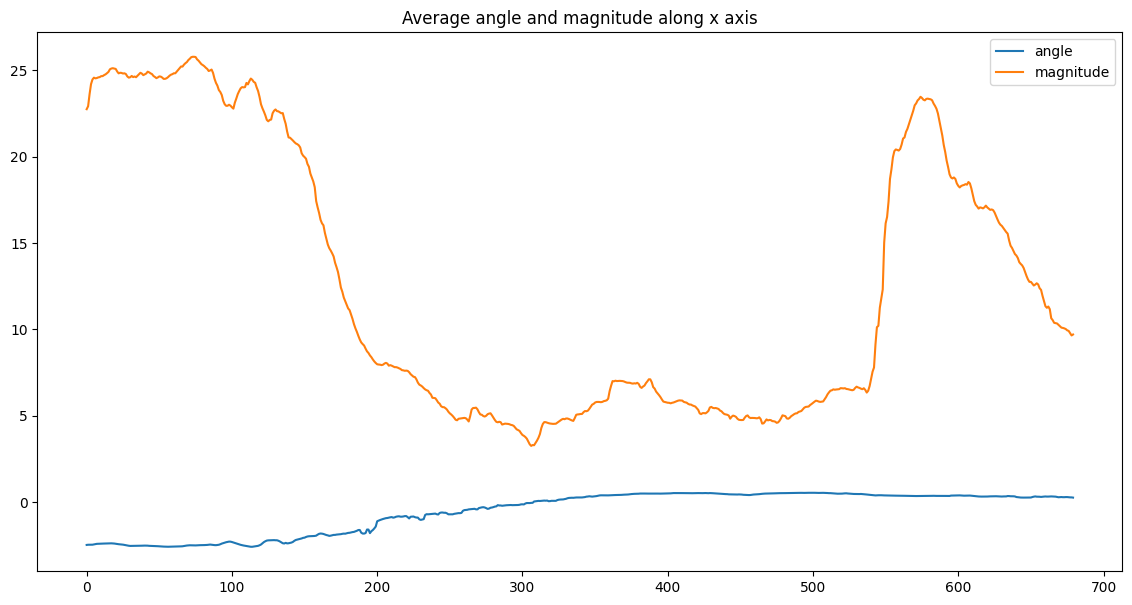

In [18]:
#rotate angle

# multiply magnitues with angle x component
angle_x = np.multiply(angle, np.cos(angle))

average_angle_along_x_axis = np.median(angle_x, axis=0)

# get average magnitude along x axis
average_magnitude_along_x_axis = np.median(magnitude, axis=0)

# overlay plots
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 7)
ax.plot(average_angle_along_x_axis)
ax.plot(average_magnitude_along_x_axis)
ax.set_title('Average angle and magnitude along x axis')
ax.legend(['angle', 'magnitude'])


# Process Videos

for each video:

- read the video
- extract the frames
- calculate the dense optic flow
- calculate the R-VP
- save the R-VP

In [10]:
# for file in files:
#     cap = cv2.VideoCapture(file)
#     frame = get_frame(cap, 0)
#     next_frame = get_frame(cap, 1)
#     if frame is not None and next_frame is not None:
#         print('Frame shape: ', frame.shape)
#     cap.release()